# Threshold Calibration and Plotting for Jingle Detection

This notebook helps you find the optimal decision threshold for your binary classifier by analyzing precision, recall, and F1 score at different thresholds. It also provides visualizations to guide threshold selection.


In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, roc_curve, auc
import joblib
import os

In [3]:
# Load validation features, metadata, and trained model
features_dir = './features'
model_path = './models/baseline_model.joblib'

# Load tabular features (X) and labels (y)
val_features = np.load(os.path.join(features_dir, 'val_features.npz'))
X_val = val_features['X_tab']

val_meta = pd.read_csv(os.path.join(features_dir, 'val_meta.csv'))
# Assumes 'label' column is 0 (neg) or 1 (pos)
y_val = val_meta['label'].values

# Load trained model
model = joblib.load(model_path)

# Get predicted probabilities for positive class
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_val)[:, 1]
else:
    y_proba = model.decision_function(X_val)
    y_proba = (y_proba - y_proba.min()) / \
        (y_proba.max() - y_proba.min())  # scale to [0,1]

In [5]:
# Apply Threshold Calibration Algorithm
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Find threshold with maximum F1
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

print(f'Best threshold: {best_threshold:.3f}')
print(
    f'Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}')

# Confusion matrix at best threshold
y_pred = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_pred)
print('Confusion matrix at best threshold:')
print(cm)

Best threshold: 0.000
Precision: 0.800, Recall: 1.000, F1: 0.889
Confusion matrix at best threshold:
[[ 0 20]
 [ 0 80]]


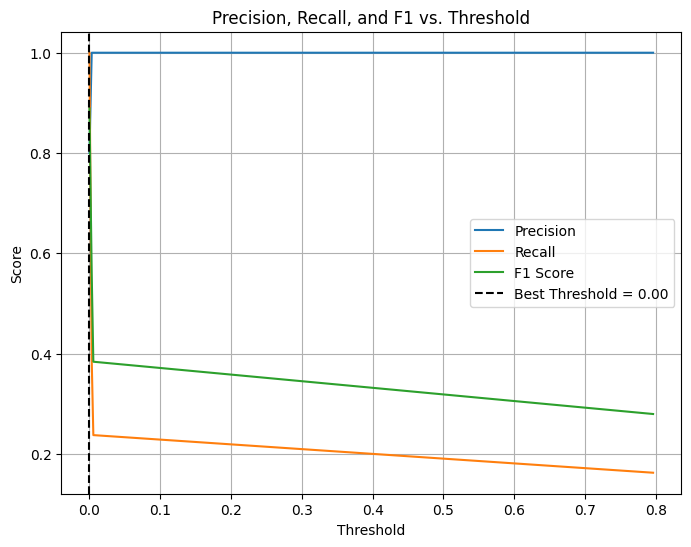

In [10]:
# Plot Calibration Results
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1s[:-1], label='F1 Score')
plt.axvline(best_threshold, color='k', linestyle='--',
            label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

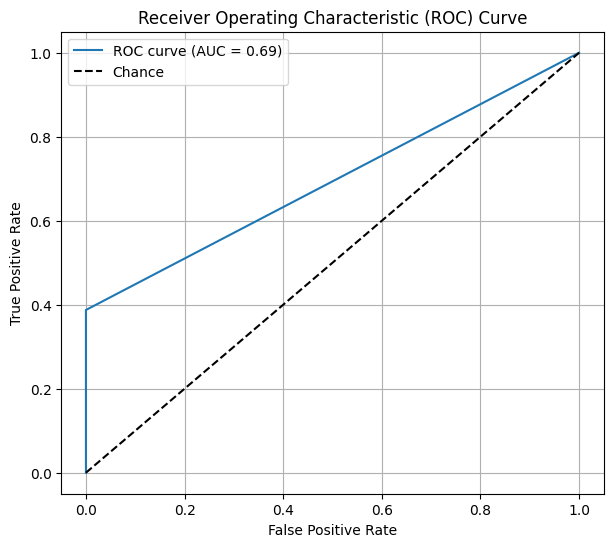

In [9]:
# Visualize Threshold Effects: ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

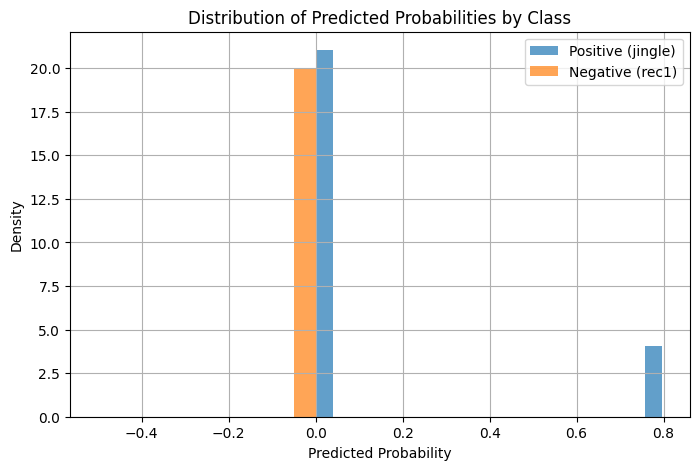

In [ ]:
# Plot predicted probability distributions for each class
plt.figure(figsize=(8, 5))
plt.hist(y_proba[y_val == 1], bins=20, alpha=0.7,
         label='Positive (jingle)', color='tab:blue', density=True)
plt.hist(y_proba[y_val == 0], bins=20, alpha=0.7,
         label='Negative (rec1)', color='tab:orange', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by Class')
plt.legend()
plt.grid(True)
plt.show()